In [2]:
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
from scipy import ndimage
from scipy.optimize import curve_fit
import etpof
from tqdm import tqdm

# %matplotlib widget

In [3]:
res_avg = np.mean([4.88918152, 4.88946346])
res_std = np.mean([0.00183618, 0.00167924])

In [4]:
imgs, files = etpof.read_image_series('PTV', 'a')

100%|██████████| 200/200 [00:00<00:00, 237.41it/s]


In [5]:
def remove_hits(img, mode):
    
    # Define different kernels
    if mode == 'single':
        kernel = np.array([[ 0, -1,  0],
                           [-1, +1, -1],
                           [ 0, -1,  0]])
    elif mode == 'horizontal':
        kernel = np.array([[ -1, -1,  -1],
                           [ 0, +1,  0],
                           [ -1, -1,  -1]])
    elif mode == 'vertical':
        kernel = np.array([[ -1,  0,  -1],
                           [-1, +1, -1],
                           [ -1,  0,  -1]])
    else:
        raise ValueError('Mode not recognized')
    
    # Binarize the image
    img_binary = cv.threshold(img, 0, 255, cv.THRESH_BINARY)[1]
    
    # Perform a hit-or-miss transform on a binary version to remove matching pixels
    img_singles = cv.morphologyEx(img_binary, cv.MORPH_HITMISS, kernel)
    
    # Edit the original image
    img[img_singles == 255] = 0
    
    return img


def remove_background(img, sigma_color1 = 50, sigma_space1 = 9,
                      sigma_color2 = 20, sigma_space2 = 3, noise_threshold=50):
    
    # TODO: Explain that masking might have been easier
    
    # # If the image has three channels, convert it to grayscale
    # if len(img.shape) == 3:
    #     img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    
    # Apply a bilateral filter to TODO: explain how the bilateral filter works
    img_proc = cv.bilateralFilter(img, d=-1, sigmaColor=sigma_color1, sigmaSpace=sigma_space1)
    
    # Apply another bilateral filter for finer detail removal
    img_proc = cv.bilateralFilter(img_proc, d=-1, sigmaColor=sigma_color2, sigmaSpace=sigma_space2)

    # Set all pixels below a certain threshold to zero with a to-zero threshold
    _, img_proc = cv.threshold(img_proc, noise_threshold, 255, cv.THRESH_TOZERO)

    # Remove a bunch of specific patterns
    img_proc = remove_hits(img_proc, 'horizontal')
    img_proc = remove_hits(img_proc, 'vertical')

    return img_proc

In [6]:
imgs_nobg = [remove_background(img) for img in tqdm(imgs)]

100%|██████████| 200/200 [00:02<00:00, 70.88it/s]


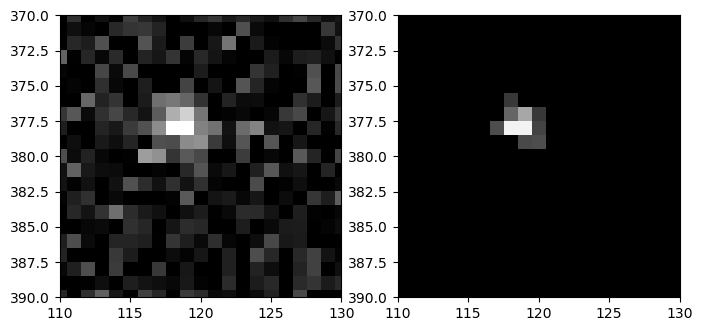

In [7]:
# Show the image and the processed image next to each other
fig, ax = plt.subplots(1,2, figsize = (8, 8))
ax[0].imshow(imgs[48], cmap = 'gray')
ax[1].imshow(imgs_nobg[48], cmap = 'gray')
ax[0].set_xlim(110, 130); ax[0].set_ylim(390, 370)
ax[1].set_xlim(110, 130); ax[1].set_ylim(390, 370)
plt.show()

In [7]:
# # Draw the contours with random colours
# img_cnt = img_rgb.copy()
# for cnt in cnts:
#     color = np.random.randint(85, 255, 3, dtype=np.uint8)
#     img_cnt = cv.drawContours(img_cnt, cnt, -1, 
#                                (int(color[0]), int(color[1]), int(color[2])), 2)

In [8]:
def find_local_max(all_idxs, all_ints):
    # Maximum filter on this (processed) region
    peak_intensities = ndimage.maximum_filter(all_ints, size=3)
    
    # Filter out maxima of 0 at the edges
    peak_intensities = np.where(peak_intensities == 0, -1, peak_intensities)
    
    # Get indices
    peak_indices = all_idxs[:, all_ints == peak_intensities]
    
    # Get the intensities of the maxima
    peak_intensities = all_ints[all_ints == peak_intensities]
    
    # If no maxima were detected
    if peak_indices.shape[1] == 0:
        # Raise an exception
        raise ValueError('No maxima detected')

    return peak_indices, peak_intensities


def remove_sublists(list_of_lists):
    """
    Remove sublists and duplicates from a list of lists.
    Source: https://www.geeksforgeeks.org/python-remove-sublists-that-are-present-in-another-sublist/
    
    ARGUMENTS:
        list_of_lists: list of lists (might be inhomogeneous)
    
    RETURNS:
        results: list of lists with sublists removed
    """
    
    # Convert each element to a set and sort by descending length
    current_sublist = []
    results = []   
    for element in sorted(map(set, list_of_lists), key = len, reverse = True):
        
        # Add only sets that are not already part of current_sublist
        if not any(element <= number for number in current_sublist):
            current_sublist.append(element)
            results.append(list(element))
         
    return results


def split_clusters(peak_idxs, neighbor_dist=1.5):
    
    # Check the Euclidian distances between the maxima
    dists = etpof.all_distances(peak_idxs[0, :], peak_idxs[1, :])
    
    # Get the indices of all the groups that are within a certain distance
    peak_clusters = [[i for i, val in enumerate(dists[:, col]) 
                 if val < neighbor_dist] for col in range(dists.shape[1])]
    
    # Remove subsets and duplicates
    peak_clusters = remove_sublists(peak_clusters)
       
    return peak_clusters

# def gaussian_peak

In [9]:
def destroy_neighbors(all_idxs, all_ints, peak_idxs, peak_ints, max_iter=3):
      
    # If there are (still) neighbors in the set of maxima...
    iteration = 1
    while peak_idxs.shape[1] > 1:

        # Perform a small Gaussian blur on the region
        all_ints = cv.GaussianBlur(all_ints, (3, 3), 0, 
                                   borderType=cv.BORDER_CONSTANT)

        # Get the new local maxima
        peak_idxs, peak_ints = find_local_max(all_idxs, all_ints)
        
        # Count the number of iterations
        iteration += 1
        
        # If the max number of iterations is reached...
        if iteration >= max_iter:
            # Throw a warning
            print('Maximum number of blurring iterations reached...')
            
            # Pick the first maximum and break the loop
            peak_idxs = peak_idxs[:, [0]]
            peak_ints = peak_ints[[0]]
            break
        
    return peak_idxs, peak_ints

[[2 5 6 6]
 [3 1 1 2]]
[[1, 2, 3], [0]]
[[5 6 6]
 [1 1 2]]
[220 220 220]
Maximum number of blurring iterations reached...
[[2]
 [3]]
[220]


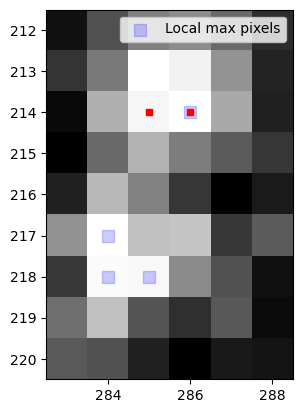

In [91]:
def find_particle_center(img, img_nobg, cnts, cnt_idx, neighbor_dist=1.5, plot=False,
                         box_marg = 2):
    
    cnt = cnts[cnt_idx]
    
    # Get the bounding box of the contour
    box_x, box_z, box_w, box_h = cv.boundingRect(cnt)
    
    # Get the intensities of the pixels in the bounding box + margin as a 2D array
    all_ints = (img[(box_z - box_marg):(box_z + box_h + box_marg),
                    (box_x - box_marg):(box_x + box_w + box_marg)]
                    .reshape(box_h + 2 * box_marg, box_w + 2 * box_marg))
    all_ints_nobg = (img_nobg[(box_z):(box_z + box_h),
                    (box_x):(box_x + box_w)]
                    .reshape(box_h, box_w))
       
    # TODO: Set pixels that are on another contour to zero
    # cnts_other = [c for c in cnts if c is not cnt]
    # mask = np.zeros_like(box_int)
    # mask = cv.drawContours(mask, cnts[4], -1, 255, -1)
    # box_int = np.where(mask != 255, box_int, 0)
    
    # Get the image coordinates corresponding to each of these pixels
    all_idxs_nobg = np.indices((box_h, box_w))
    
    # Get the local maxima in the region
    peak_idxs, peak_ints = find_local_max(all_idxs_nobg, all_ints_nobg)
            
    # Split into groups
    clusters = split_clusters(peak_idxs, neighbor_dist=neighbor_dist)
    
    print(peak_idxs)
    print(clusters)
    
    # Set up plot of the unprocessed box
    if plot:
        fig, ax = plt.subplots()
        # Draw the contour
        # img_cnt = img_nobg.copy()
        # img_cnt = cv.drawContours(img_cnt, [cnt], -1, 255, 1)
        # ax.imshow(img_cnt, cmap = 'gray')
        ax.imshow(img, cmap = 'gray')
        ax.invert_yaxis()
        ax.set_xlim(box_x - box_marg - 0.5, box_x + box_w + box_marg + 0.5)
        ax.set_ylim(box_z + box_h + box_marg + 0.5, box_z - box_marg - 0.5)
    
        # Plot all maxima found originally
        peak_coords = peak_idxs + np.array([box_z, box_x])[:, None]
        ax.scatter(*np.flipud(peak_coords), c ='b', s = 75, marker = 's',
                   alpha=0.2, label = 'Local max pixels')
    
    
    # For each cluster (might only be one in many cases)...
    x_max, z_max = [], []
    for cluster in clusters:
        
        peak_idx = peak_idxs[:, cluster]
        print(peak_idx)
        peak_int = peak_ints[cluster]
        print(peak_int)
        
        # Deal with neighbouring maxima
        peak_idx, peak_int = destroy_neighbors(all_idxs_nobg, all_ints_nobg,
                                    peak_idx, peak_int)
        
        # Convert to real coordinates and add to plot
        if plot:
            peak_coord = peak_idx + np.array([box_z, box_x])[:, None] 
            ax.scatter(*np.flipud(peak_coord), c ='r', s = 15, marker = 's')
    
    if plot:
        plt.legend()
        plt.show()
    # 
    # # Get the real x and z coordinates
    # box_px = box_idx + np.array([box_z - box_marg, box_x - box_marg])[:, None, None]
    # box_px_max = box_idx_max + np.array([box_z - box_marg, box_x - box_marg])[:, None]        
    # box_px_max_old = box_idx_max_old + np.array([box_z - box_marg, box_x - box_marg])[:, None]        
    # 
    # # SUBPIXEL DETECTION
    # # When only one maximum was detected, the entire region can be used to fit a 
    # # Gaussian in two directions
    # 
    # # Use curve_fit to fit a Gaussian to the region
    # def gaussian(x, a, x0, sigma):
    #     return a * np.exp(-((x - x0)**2) / (2 * sigma**2))
    # 
    # # Get slices around box_idx_max in the x and z direction
    # row_px = box_px[1, box_idx_max[0], :].flatten()
    # col_px = box_px[0, :, box_idx_max[1]].flatten()
    # 
    # row_int = box_int[box_idx_max[0], :].flatten()
    # col_int = box_int[:, box_idx_max[1]].flatten()
    # 
    # # Initial parameters
    # # TODO: Change sigma to number of pixels that are at maximum
    # a = box_int[*box_idx_max][0]
    # x0 = box_px_max[1][0]
    # z0 = box_px_max[0][0]
    # sigma_x = 1
    # sigma_z = 1
    # 
    # 
    # popt_row, _ = curve_fit(gaussian, row_px, row_int, p0=[a, x0, sigma_x])
    # popt_col, _ = curve_fit(gaussian, col_px, col_int, p0=[a, z0, sigma_z])
    # 
    # # Get the coordinates of the maximum of the Gaussian
    # x_max = popt_row[1]
    # z_max = popt_col[1]
    # 
    # # Plot the unprocessed box, maximum pixels and particle center
    # fig, ax = plt.subplots()
    # ax.imshow(img, cmap = 'gray')
    # ax.invert_yaxis()
    # ax.set_xlim(box_x - box_marg - 0.5, box_x + box_w + box_marg + 0.5)
    # ax.set_ylim(box_z + box_h + box_marg + 0.5, box_z - box_marg - 0.5)
    # 
    # ax.scatter(*np.flipud(box_px_max_old), c ='b', s = 75, marker = 's',
    #            alpha=0.2, label = 'Local max pixels')
    # ax.scatter(*np.flipud(box_px_max), c ='r', s = 15, marker = 's',
    #            label = 'Post-blur max pixel')
    # ax.scatter(x_max, z_max, c = 'r', s = 100, marker = '+', 
    #            label = 'Gaussian subpixel')
    # plt.legend()
    # plt.show()
    # 
    # return x_max, z_max

# def detect_particles(img, img_nobg):

# Todo: FOR LOOP!

cnt_idx = 14 # img 0 cnt 15 max iterations, cnt 14 double peak goes wrong!!

img_nobg = imgs_nobg[0]
img = imgs[0]

# Find the contours in the background-less image
cnts, _ = cv.findContours(img_nobg, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# Filter out contours that are too small
cnts = [cnt for cnt in cnts if cv.contourArea(cnt) > 1]

# for cnt in cnts:

find_particle_center(img, img_nobg, cnts, cnt_idx, plot=True, neighbor_dist=1.5, box_marg = 0)

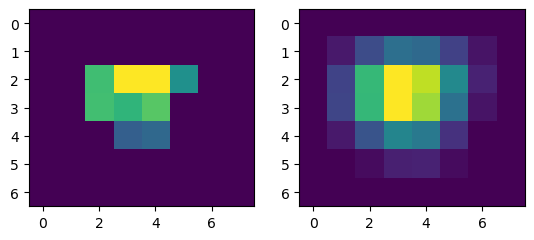

In [57]:
test_img = np.array([[  0,   0,   0,   0,   0,   0,   0,   0],
 [  0,   0,   0,   0,   0,   0,   0,   0],
 [  0,   0, 146, 211, 211, 106,   0,   0],
 [  0,   0, 147, 138, 156,   0,   0,   0],
 [  0,   0,   0,  64,  71,   0,   0,   0],
 [  0,   0,   0,   0,   0,   0,   0,   0],
 [  0,   0,   0,   0,   0,   0,   0,   0]], dtype=np.uint8)

fig,ax=plt.subplots(1,2)

ax[0].imshow(test_img)
ax[1].imshow(cv.GaussianBlur(test_img, (3, 3), 0))

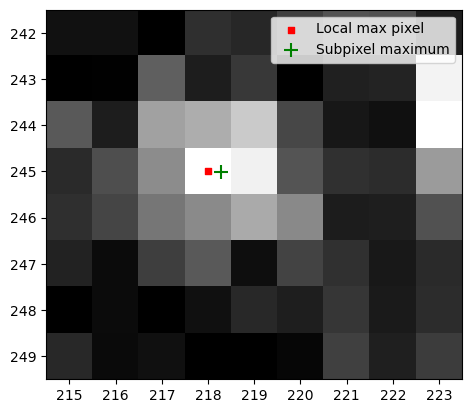

In [84]:
# # Get all pixels enclosed by the contour
# mask = np.zeros_like(img_proc)
# mask = cv.drawContours(mask, [cnt], -1, 255, -1)
# 
# # Get the x and z coordinates and intensities of the pixels
# cnt_coords = np.array(np.where(mask == 255))
# # box_int = img[np.where(mask == 255)]

# # Get 2D local maxima in this blob
# peaks, _ = find_peaks(box_int, distance=5, prominence=5)


# Show this contour on the original image
fig, ax = plt.subplots()
ax.imshow(img, cmap = 'gray')
ax.set_xlim(x - box_marg - 0.5, x + w + box_marg + 0.5)
ax.set_ylim(z + h + box_marg + 0.5, z - box_marg - 0.5)

# Scatter plot of peaks
ax.scatter(*np.flipud(box_px_max), c ='r', s = 20, marker = 's',
           label = 'Local max pixel')
ax.scatter(x_max, z_max, c = 'g', s = 100, marker = '+',
           label = 'Subpixel maximum')
plt.legend()
plt.show()



In [ ]:
# Simple blob detection
detector = cv.SimpleBlobDetector()

# Detect blobs.
keypoints = detector.detect(img_proc)

# Draw detected blobs as red circles.
# cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensures the size of the circle corresponds to the size of blob
img_with_keypoints = cv.drawKeypoints(img_proc, keypoints, np.array([]), 
                                      (0, 255, 0),
                                      cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Show keypoints
fig, ax = plt.subplots(1,1, figsize = (15, 15))

ax.imshow(img_with_keypoints, cmap = 'gray')
ax.set_xlim(roi[2], roi[3])
ax.set_ylim(roi[0], roi[1])
plt.show()
